Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Probability of surges

In [45]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import xgboost
import sklearn.metrics as metrics
from sklearn.utils import resample


import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry import Polygon

import rioxarray as rx

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [12]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced_clean/df_modelling.csv', index_col=['rgiid', 'x', 'y'])
df_main

/home/colili/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Surge   BgnDate  EndDate   CenLon  \
rgiid          x             y                                                 
RGI60-07.00004 524634.335707 8.539882e+06      0  20080901 -9999999  15.9932   
               524633.930457 8.539906e+06      0  20080901 -9999999  15.9932   
               524657.521964 8.539931e+06      0  20080901 -9999999  15.9932   
               524681.113471 8.539955e+06      0  20080901 -9999999  15.9932   
               524704.704977 8.539980e+06      0  20080901 -9999999  15.9932   
...                                          ...       ...      ...      ...   
RGI60-07.01567 534310.362510 8.675249e+06      3  20040713 -9999999  16.5502   
               534309.250485 8.675291e+06      3  20040713 -9999999  16.5502   
               534308.138459 8.675333e+06      3  20040713 -9999999  16.5502   
               534307.026431 8.675375e+06      3  20040713 -9999999  16.5502   
               534347.900282 8.675418e+06      3  20040713 -9999999  16.5502   

                                            CenLat   Area  Zmin  Zmax  Zmed  \
rgiid          x             y                                                
RGI60-07.00004 524634.335707 8.539882e+06  76.9423  1.044   665   933   799   
               524633.930457 8.539906e+06  76.9423  1.044   665   933   799   
               524657.521964 8.539931e+06  76.9423  1.044   665   933   799   
               524681.113471 8.539955e+06  76.9423  1.044   665   933   799   
               524704.704977 8.539980e+06  76.9423  1.044   665   933   799   
...                                            ...    ...   ...   ...   ...   
RGI60-07.01567 534310.362510 8.675249e+06  78.1217  5.350   304   970   656   
               534309.250485 8.675291e+06  78.1217  5.350   304   970   656   
               534308.138459 8.675333e+06  78.1217  5.350   304   970   656   
               534307.026431 8.675375e+06  78.1217  5.350   304   970   656   
               534347.900282 8.675418e+06  78.1217  5.350   304   970   656   

                                           Slope  ...    Runoff         ELA  \
rgiid          x             y                    ...                         
RGI60-07.00004 524634.335707 8.539882e+06   13.8  ...  1.110227  431.471268   
               524633.930457 8.539906e+06   13.8  ...  1.105706  431.784498   
               524657.521964 8.539931e+06   13.8  ...  1.100061  432.103017   
               524681.113471 8.539955e+06   13.8  ...  1.094416  432.421537   
               524704.704977 8.539980e+06   13.8  ...  1.088771  432.740057   
...                                          ...  ...       ...         ...   
RGI60-07.01567 534310.362510 8.675249e+06   11.7  ...  2.127417  627.625366   
               534309.250485 8.675291e+06   11.7  ...  2.076787  627.625366   
               534308.138459 8.675333e+06   11.7  ...  2.005969  627.625366   
               534307.026431 8.675375e+06   11.7  ...  1.935151  627.625366   
               534347.900282 8.675418e+06   11.7  ...  1.917944  627.625366   

                                               beta       cmb  Bed_slope  \
rgiid          x             y                                             
RGI60-07.00004 524634.335707 8.539882e+06  0.005068  1.388794        NaN   
               524633.930457 8.539906e+06  0.005069  1.394411        NaN   
               524657.521964 8.539931e+06  0.005069  1.392706        NaN   
               524681.113471 8.539955e+06  0.005068  1.391001  12.654898   
               524704.704977 8.539980e+06  0.005068  1.389296  12.654898   
...                                             ...       ...        ...   
RGI60-07.01567 534310.362510 8.675249e+06  0.004614 -1.423469   4.401905   
               534309.250485 8.675291e+06  0.004618 -1.395654   4.401905   
               534308.138459 8.675333e+06  0.004620 -1.382369  -0.158243   
               534307.026431 8.675375e+06  0.004621 -1.369084  -0.158243   
               534347.900282 8.675

In [4]:
df = df_main.drop(df_main[df_main['Surge']==9].index)
df = df.drop(df_main[df_main['Surge']==1].index)
# df = df_main.drop(df_main[df_main['Surge']==2].index)
df = df.drop(columns = ['BgnDate', 'EndDate', 'CenLon', 'CenLat', 'Area',
       'Zmin', 'Zmax', 'Zmed', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'Linkages', 'Name', 'check_geom', 'geometry', 'ELA', 'beta',
        'Bed_slope', 'Surface_slope', 'cmb'])
df.dropna(how='any', inplace=True)

In [5]:
df.groupby('Surge').count()

,Slope,TermType,bed,thickness,surface_elevation,width_centerline,Runoff,WHsin,WH,dummy,SMB_calc
Surge,,,,,,,,,,,
0,66717,66717,66717,66717,66717,66717,66717,66717,66717,66717,66717
2,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195,4195
3,10744,10744,10744,10744,10744,10744,10744,10744,10744,10744,10744


In [6]:
df['Surge'] = df['Surge'].replace({3: 1, 2:1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    66717
1    14939
Name: label, dtype: int64

In [9]:
df[df['label']==1].shape[0]

14939

In [10]:
df.shape

(81656, 12)

### Resampled

In [7]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [12]:
df_downsampled.shape

(29878, 12)

In [8]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [9]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'width_centerline',
 'Runoff',
 'WHsin',
 'WH',
 'dummy',
 'SMB_calc']

# Gradient boosting

In [15]:
import xgboost
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [13]:
df_main = df_main.drop(columns = ['BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'Zmin', 'Zmax', 'Zmed', 'Aspect', 'Lmax', 'Status', 'Connect',
       'Form', 'Linkages', 'check_geom', 'geometry',
        'Bed_slope', 'Surface_slope'])

In [14]:
df_main.columns

Index(['Surge', 'Area', 'Slope', 'TermType', 'Name', 'bed', 'thickness',
       'surface_elevation', 'width_centerline', 'Runoff', 'ELA', 'beta', 'cmb',
       'WHsin', 'WH', 'dummy', 'SMB_calc'],
      dtype='object')

In [15]:
df_main.dropna().shape

(72016, 17)

In [16]:
df_main.dropna(inplace=True)

In [17]:
test_full_labels = df_main['Surge']
# test_full = df_main.dropna(inplace=True)
test_full = df_main.drop(columns=['Surge', 'Area', 'Name', 'ELA', 'beta', 'cmb'])

test_full

Slope  TermType        bed  \
rgiid          x             y                                          
RGI60-07.00006 537340.603079 8.536963e+06   12.6         1  565.43870   
               537277.114391 8.537023e+06   12.6         1  547.37540   
               537213.625703 8.537084e+06   12.6         1  514.92160   
               537150.137016 8.537144e+06   12.6         1  468.15363   
               537088.154264 8.537143e+06   12.6         1  468.15363   
...                                          ...       ...        ...   
RGI60-07.01567 534269.488654 8.675206e+06   11.7         0  237.64468   
               534310.362510 8.675249e+06   11.7         0  233.07228   
               534309.250485 8.675291e+06   11.7         0  233.07228   
               534308.138459 8.675333e+06   11.7         0  233.18828   
               534307.026431 8.675375e+06   11.7         0  233.18828   

                                           thickness  surface_elevation  \
rgiid          x             y                                            
RGI60-07.00006 537340.603079 8.536963e+06  23.561293          589.00000   
               537277.114391 8.537023e+06  24.624578          572.00000   
               537213.625703 8.537084e+06  27.078419          542.00000   
               537150.137016 8.537144e+06  33.846375          502.00000   
               537088.154264 8.537143e+06  33.846375          502.00000   
...                                              ...                ...   
RGI60-07.01567 534269.488654 8.675206e+06  50.380424          288.02512   
               534310.362510 8.675249e+06  46.717087          279.78937   
               534309.250485 8.675291e+06  46.717087          279.78937   
               534308.138459 8.675333e+06  47.159560          280.34784   
               534307.026431 8.675375e+06  47.159560          280.34784   

                                           width_centerline    Runoff  \
rgiid          x             y                                          
RGI60-07.00006 537340.603079 8.536963e+06       1144.919151  1.520206   
               537277.114391 8.537023e+06       1105.995748  1.453610   
               537213.625703 8.537084e+06       1069.477866  1.434204   
               537150.137016 8.537144e+06       1244.957956  1.451109   
               537088.154264 8.537143e+06       1162.234761  1.468375   
...                                                     ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06        278.553621  2.123592   
               534310.362510 8.675249e+06        256.755923  2.127417   
               534309.250485 8.675291e+06        238.477978  2.076787   
               534308.138459 8.675333e+06        226.342325  2.005969   
               534307.026431 8.675375e+06        215.631320  1.935151   

                                                  WHsin        WH     dummy  \
rgiid          x             y                                                
RGI60-07.00006 537340.603079 8.536963e+06 -20088.290815  0.020579  0.121145   
               537277.114391 8.537023e+06 -21764.237917  0.022265  0.167446   
               537213.625703 8.537084e+06  28786.494698  0.025319  0.459727   
               537150.137016 8.537144e+06   8366.744828  0.027187  0.481836   
               537088.154264 8.537143e+06   7810.803277  0.029122  0.350271   
...                                                 ...       ...       ...   
RGI60-07.01567 534269.488654 8.675206e+06  -8877.735508  0.180864  0.621735   
               534310.362510 8.675249e+06 -11421.363223  0.181951  0.569856   
               534309.250485 8.675291e+06 -10608.299012  0.195897  0.044070   
               534308.138459 8.675333e+06  -1682.075458  0.208355  0.720951   
               534307.026431 8.675375e+06  -1602.476034  0.218705  0.342674   

                                           SMB_calc  
rgiid          x             y                       
RGI60-07.00006 537340.603079 8.

In [20]:
dmatrix_train = xgboost.DMatrix(train, label=train_labels)
dmatrix_test = xgboost.DMatrix(test[test.columns], label=test_labels)

In [21]:
# params = {'objective':'reg:logistic', 'num_boost_round':20000, 'max_depth':1, 'scale_pos_weight':0.5}
params = {'objective':'reg:logistic', 'max_depth':1, 'scale_pos_weight':0.5}

xgb = xgboost.XGBClassifier(**params)
xgb.fit(train, train_labels)
# xgb = xgboost.train(params, dmatrix_train, num_boost_round=20000)

/home/colili/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=0.5, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
index = test.index
index

MultiIndex([('RGI60-07.01396',  539242.5311852772, 8537604.683440438),
            ('RGI60-07.00584',  539244.2293263884, 8739903.564008035),
            ('RGI60-07.00025',  669438.6073954102, 8816802.255178852),
            ('RGI60-07.01564',  568466.6931550484, 8772363.037703848),
            ('RGI60-07.00027',  680522.8092478139,  8863356.96354941),
            ('RGI60-07.00063',  649843.3414775232, 8671665.601856979),
            ('RGI60-07.00943',  684414.0250406681, 8656995.513415005),
            ('RGI60-07.00892',  603026.6383339043, 8745884.401582925),
            ('RGI60-07.00067',  609731.0588409506, 8836450.206113039),
            ('RGI60-07.00249',  530370.4200120049, 8552070.685124371),
            ...
            ('RGI60-07.01059', 515730.08109830006,  8663896.55380423),
            ('RGI60-07.00492',  436869.9414497279, 8735831.992290035),
            ('RGI60-07.00980',  656146.6789484166, 8719603.100316625),
            ('RGI60-07.00990',  581015.5567392523, 8795520.59

In [23]:
test_full.index

MultiIndex([('RGI60-07.00006', 537340.6030786886, 8536962.729457755),
            ('RGI60-07.00006', 537277.1143909006, 8537023.206295874),
            ('RGI60-07.00006', 537213.6257034478, 8537083.683127213),
            ('RGI60-07.00006', 537150.1370163298, 8537144.159951767),
            ('RGI60-07.00006', 537088.1542639694, 8537142.654018957),
            ('RGI60-07.00006', 537024.6655807449, 8537203.130833503),
            ('RGI60-07.00006', 536961.1768978542, 8537263.607641263),
            ('RGI60-07.00006', 536897.6882152973, 8537324.084442247),
            ('RGI60-07.00006',  536834.199533074, 8537384.561236443),
            ('RGI60-07.00006', 536770.7108511837, 8537445.038023861),
            ...
            ('RGI60-07.01567', 534233.0628686899, 8674994.491536722),
            ('RGI60-07.01567',  534231.950853308, 8675036.477414005),
            ('RGI60-07.01567', 534230.8388363951, 8675078.463291207),
            ('RGI60-07.01567', 534229.7268179511, 8675120.449168332),
    

In [24]:
# predictions_xgboost = xgb.predict(dmatrix_test)
predictions_xgboost = xgb.predict(test_full)
probabilities_xgboost = xgb.predict_proba(test_full)
# probabilities_xgboost = xgb.predict_proba(test)
# probabilities_xgboost = xgb.predict_proba(dmatrix_test)
prob_0 = []
prob_1 = []
for n in np.arange(0, probabilities_xgboost.shape[0], 1):
    prob_0.append(probabilities_xgboost[:][:][n][0])
    prob_1.append(probabilities_xgboost[:][:][n][1])
    
df_probability_surge_full = pd.DataFrame({'Probability_0':prob_0, 'Probability_1':prob_1, 'Predictions':predictions_xgboost}, index=test_full.index)
df_probability_surge_full.reset_index(['x', 'y'], inplace=True)

In [25]:
df_probability_surge_full

,x,y,Probability_0,Probability_1,Predictions
rgiid,,,,,
RGI60-07.00006,537340.603079,8.536963e+06,0.817584,0.182416,0
RGI60-07.00006,537277.114391,8.537023e+06,0.787967,0.212033,0
RGI60-07.00006,537213.625703,8.537084e+06,0.746651,0.253349,0
RGI60-07.00006,537150.137016,8.537144e+06,0.756178,0.243822,0
RGI60-07.00006,537088.154264,8.537143e+06,0.756178,0.243822,0
...,...,...,...,...,...
RGI60-07.01567,534269.488654,8.675206e+06,0.732285,0.267715,0
RGI60-07.01567,534310.362510,8.675249e+06,0.732285,0.267715,0
RGI60-07.01567,534309.250485,8.675291e+06,0.732285,0.267715,0


## Scale bar

In [39]:
def scale_bar(ax, length=None, location=(0.8, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
#     tmc = ccrs.TransverseMercator(sbllx, sblly)
    tmc = ccrs.UTM(33, southern_hemisphere=False, globe=None)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom', fontsize=15)

## Probaility map

/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/colili/anaconda3/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


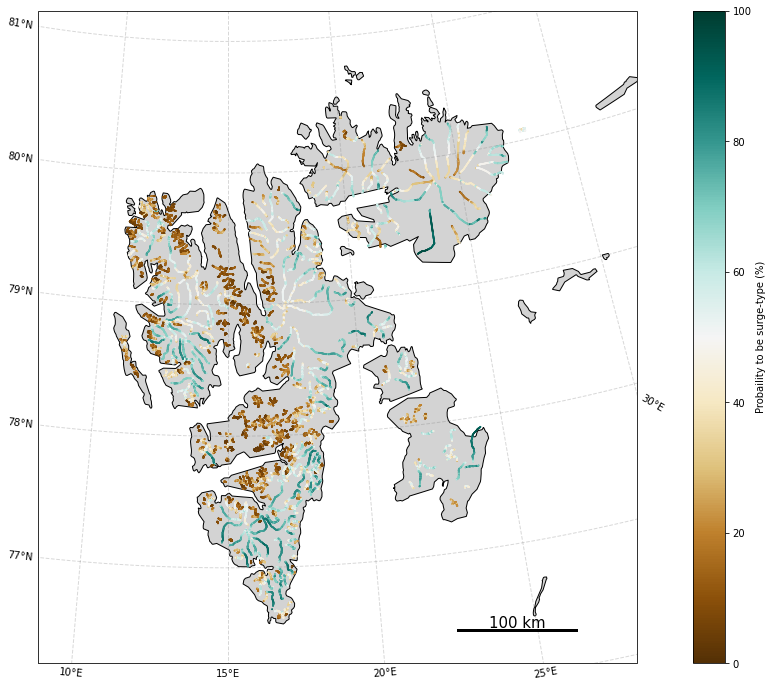

In [54]:
# avg_loc_center = svalbard_glaciers[svalbard_glaciers.GLACIER_NAME.isin(centerlines_glacs)].groupby('GLACIER_NAME').mean()
svalbard_bounding_box = {'left_lon':9.9, 'right_lon':26.2, 'bottom_lat':76.276, 'top_lat':80.5}
fig, ax = plt.subplots(1, figsize=(20,12))

# proj = ccrs.PlateCarree()                       # the projection you want to use, many are supported, 
# proj = ccrs.Mercator() 
proj = ccrs.UTM(33, southern_hemisphere=False, globe=None)# the projection you want to use, many are supported, 
                                                # this one is the standard for geographic coordinates
    
ax = plt.axes(projection=proj)                  # sets the projection

ax.add_feature(cartopy.feature.OCEAN            # add ocean feature
               , zorder=0                       # layer where ocean should plot; 0 is base   
               , facecolor='w'                  # color of the ocean
              )           

ax.add_feature(cartopy.feature.LAND             # add continent feature
               , zorder=0                       # layer where continent should plot; 0 is base
               , edgecolor='black'              # coastline color
               , facecolor='lightgray'          # continent color
              ) 

# ax.add_geometries(outlines['geometry'], crs=proj) #plot the outlines of glaciers

# ax.coastlines(resolution='110m')                # the level of resolution to render the drawings, 
                                                # see documentation for more details
                
gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=1                   # line properties can be changed similar to matplotlib
                , color='gray'
                , alpha=0.3
                , linestyle='--')
    
gl.xlabels_top = gl.ylabels_right = gl.ylabels_top = False 
gl.ylabels_bottom = True # where labels shouldn't be
gl.xlines = True  
gl.ylines = True  # turn off x-axis
gl.xlocator = mticker.FixedLocator([10, 15, 20, 25, 30])        # sets longitude tick marks
# gl.ylocator = mticker.FixedLocator([-180, -90, 0, 90, 180])  
gl.xformatter = LONGITUDE_FORMATTER                                # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

ax.set_extent([svalbard_bounding_box['left_lon']-1,
               svalbard_bounding_box['right_lon']+2,
               svalbard_bounding_box['bottom_lat'],
               svalbard_bounding_box['top_lat']+0.5
              ], crs=ccrs.PlateCarree())

cbar = ax.scatter(df_probability_surge_full.x.values
        ,df_probability_surge_full.y.values               # plots your data points on the axes
#         , marker='o'                                 # symbol for data point
        , marker='.'                                 # symbol for data point
        , s=2                                 # symbol for data point
        , c=df_probability_surge_full.Probability_1*100
        , cmap = 'BrBG'# symbol facecolor
#         , edgecolor='black'                          # symbol edgecolor
        , alpha=1, vmin=0, vmax=100
#         , s=250# opacity
#         , transform=ccrs.PlateCarree()
#         ,label='Not observed'
          )              # projection to plot data in

fig.colorbar(cbar, label='Probaility to be surge-type (%)')
scale_bar(ax, 100)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/map_proba_svalbard.pdf', bbox_inches='tight')

# Comparison with RGI

In [42]:
df_compare = df_main.join(df_probability_surge_full.set_index(['x', 'y'], append=True), on=['rgiid', 'x', 'y'])

## Cumulative probaility function

In [43]:
def gethist(data):
    h, e = np.histogram(data, bins=np.linspace(0, 1, 101))
#     print(h)
    h = h/h.sum()
#     print(h)
    return h.cumsum(), e

In [46]:
cmap = mpl.cm.get_cmap('BrBG')

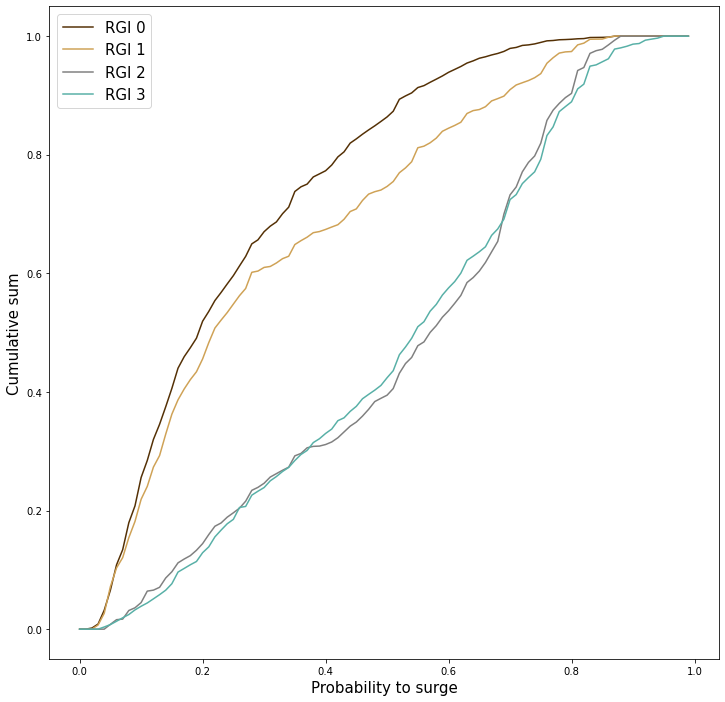

In [55]:
fig, ax = plt.subplots(figsize=(12, 12))

data = df_compare[df_compare.Surge==0].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 0', color=cmap(0))

data = df_compare[df_compare.Surge==1].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 1', color=cmap(0.25))

data = df_compare[df_compare.Surge==2].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 2', color='grey')

data = df_compare[df_compare.Surge==3].copy()
h, e = gethist(data['Probability_1'])
ax.plot(e[:-1], h, label='RGI 3', color=cmap(0.75))
ax.set_xlabel('Probability to surge', fontsize=15)
ax.set_ylabel('Cumulative sum', fontsize=15)

ax.legend(fontsize=15)

plt.savefig('/home/colili/Documents/PhD/project_john/Figure_produced/Raw/cumulative_proba.pdf', bbox_inches='tight')